In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据

In [2]:
from trasim_simplified.util.tools import load_from_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix

# 读取轨迹数据
traj_s_full_clb: dict[str, dict[str, pd.DataFrame]] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_traj_s.pkl")
traj_s_cut_pos = {v_id: len(df_pair) for v_id, df_pair in traj_s_full_clb["dec"].items()}

traj_s_full: dict[str, pd.DataFrame] = {v_id: pd.concat([df_pair, traj_s_full_clb["acc"][v_id]]) for v_id, df_pair in traj_s_full_clb["dec"].items()}
clb_x_s = [traj_s_full[k][TI.x] for k in traj_s_full.keys()]
clb_v_s = [traj_s_full[k][TI.v] for k in traj_s_full.keys()]
obs_lx_s = [traj_s_full[k][Prefix.leader + TI.x] for k in traj_s_full.keys()]
obs_lv_s = [traj_s_full[k][Prefix.leader + TI.v] for k in traj_s_full.keys()]
leaderL_s = [traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in traj_s_full.keys()]
id_s = [k for k in traj_s_full.keys()]
assert len(id_s) == len(set(id_s))
print(len(id_s))

# 读取标定参数
param_df: pd.DataFrame = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_param_df.pkl")
param_df

133


,s0,s1,v0,T,omega,d,delta,v_ID,ObjV
0,3.367405,-0.0,50.000000,0.586548,1.195860,0.318813,10.0,280,20.446222
1,2.188234,0.0,14.898263,0.140734,2.226179,1.893512,1.0,282,72.459121
2,6.313324,-0.0,16.045856,1.583061,0.845246,9.671251,9.0,298,54.787953
3,0.879316,-0.0,32.721860,0.672054,1.656269,3.744626,1.0,302,25.827953
4,4.602900,0.0,41.824750,1.477022,1.692826,8.403208,3.0,322,33.869920
...,...,...,...,...,...,...,...,...,...
128,1.650314,0.0,44.028852,0.937281,1.371234,4.418636,1.0,2761,41.097679
129,4.003811,0.0,19.466078,1.156578,1.227376,9.999991,2.0,2764,34.202032
130,4.889622,-0.0,22.636509,0.376377,1.576178,0.714813,1.0,2775,4.447199
131,1.246643,0.0,14.800041,0.995808,0.868858,0.103238,3.0,2779,49.210656


In [3]:
from trasim_simplified.core.constant import CFM
from trasim_simplified.core.kinematics.cfm.CFModel_IDM import cf_IDM_acc_module, cf_IDM_equilibrium_module

dt = 0.1
cf_name = CFM.IDM
cf_func = cf_IDM_acc_module
cf_e = cf_IDM_equilibrium_module

In [4]:
from trasim_simplified.util.hysteresis.intensity import cal_sv_intensity
from trasim_simplified.core.constant import TrackInfo as TI

def single_traj_run(cf_func_, cf_e_, cf_param, clb_v, clb_x, obs_lx, obs_lv, leaderL, v_id, k_values):
    init_v = np.array(clb_v)[0]
    init_x = np.array(clb_x)[0]
    result_ = []
    for k in k_values:
        cf_param.update({"k_speed": k[0], "k_space": k[1], "k_zero": k[2]})
        sim_pos, sim_speed, sim_acc, sim_cf_acc = simulation(
            cf_func_,
            init_v=init_v,
            init_x=init_x,
            obs_lx=obs_lx, obs_lv=obs_lv, dt=dt,
            cf_param=cf_param,
            leaderL=leaderL)
        dec_end_pos = traj_s_cut_pos[v_id]
        res = cal_sv_intensity(
            dec_s=obs_lx[: dec_end_pos] - sim_pos[: dec_end_pos],
            dec_v=sim_speed[: dec_end_pos],
            acc_s=obs_lx[dec_end_pos:] - sim_pos[dec_end_pos: ],
            acc_v=sim_speed[dec_end_pos: ],
            cf_e=cf_e_,
            cf_param=cf_param)
        result_.append([k[0], k[1], k[2], *res])
    return result_

In [5]:
from trasim_simplified.core.kinematics.cfm import get_cf_default_param

cf_params = {v_id: {name: param_df[param_df[TI.v_ID] == v_id][name].iloc[0] for name in get_cf_default_param(cf_name).keys()} for v_id in id_s}
cf_params

{280: {'v0': 50.0,
  's0': 3.3674049377441406,
  's1': -0.0,
  'delta': 10.0,
  'T': 0.5865478515625,
  'omega': 1.1958604812622078,
  'd': 0.31881332397460965},
 282: {'v0': 14.89826316833496,
  's0': 2.188234329223633,
  's1': 0.0,
  'delta': 1.0,
  'T': 0.1407337188720703,
  'omega': 2.2261789321899412,
  'd': 1.8935120582580587},
 298: {'v0': 16.045856189727782,
  's0': 6.313323974609375,
  's1': -0.0,
  'delta': 9.0,
  'T': 1.5830612182617188,
  'omega': 0.8452455520629882,
  'd': 9.671251296997069},
 302: {'v0': 32.72186040878296,
  's0': 0.8793163299560547,
  's1': -0.0,
  'delta': 1.0,
  'T': 0.6720542907714844,
  'omega': 1.6562691688537585,
  'd': 3.74462594985962},
 322: {'v0': 41.82475004196165,
  's0': 4.602899551391602,
  's1': 0.0,
  'delta': 3.0,
  'T': 1.4770221710205078,
  'omega': 1.692826175689698,
  'd': 8.403208446502687},
 363: {'v0': 49.98629455566406,
  's0': 3.2078933715820312,
  's1': -0.0,
  'delta': 10.0,
  'T': 1.6393184661865234,
  'omega': 1.350236415863

In [36]:
from itertools import product
from trasim_simplified.util.calibrate.follow_sim import simulation
import joblib

# pos = np.logspace(-2, 1, 10, endpoint=True)
pos = np.arange(0.1, 5.2, 0.5)
print(pos)
k_list = list(product(pos, pos, pos))
# for clb_v, clb_x, obs_lx, obs_lv, leaderL, v_id in zip(clb_v_s, clb_x_s, obs_lx_s, obs_lv_s, leaderL_s, id_s):
#     single_traj_run(cf_func, cf_e, cf_params[v_id], clb_v, clb_x, obs_lx, obs_lv, leaderL, v_id, k_list)
#     print("OK")

result = joblib.Parallel(n_jobs=4)(
    joblib.delayed(single_traj_run)(cf_func, cf_e, cf_params[v_id], clb_v, clb_x, obs_lx, obs_lv, leaderL, v_id, k_list) for clb_v, clb_x, obs_lx, obs_lv, leaderL, v_id in zip(clb_v_s, clb_x_s, obs_lx_s, obs_lv_s, leaderL_s, id_s))

[0.1 0.6 1.1 1.6 2.1 2.6 3.1 3.6 4.1 4.6 5.1]


In [37]:
result_df = pd.DataFrame(columns=["k_speed", "k_space", "k_zero", "dec_vs", "acc_vs", "total_vs", "dec_ts", "acc_ts", "total_ts", "min_speed", "max_speed", "dec_step", "acc_step"])

for i, v_id in enumerate(id_s):
    temp_df = pd.DataFrame(np.array(result[i]), columns=["k_speed", "k_space", "k_zero", "dec_vs", "acc_vs", "total_vs", "dec_ts", "acc_ts", "total_ts", "min_speed", "max_speed", "dec_step", "acc_step"])
    temp_df[TI.v_ID] = v_id
    result_df = pd.concat([result_df, temp_df], axis=0)
result_df[TI.v_ID] = result_df[TI.v_ID].astype(int)
result_df

C:\Users\Enze Zhao\AppData\Local\Temp\ipykernel_6908\3412607411.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, temp_df], axis=0)


,k_speed,k_space,k_zero,dec_vs,acc_vs,total_vs,dec_ts,acc_ts,total_ts,min_speed,max_speed,dec_step,acc_step,v_ID
0,0.1,0.1,0.1,-2.915215,80.851064,77.935849,4.881889,92.489002,63.423065,1.898593,5.682855,120.0,282.0,280
1,0.1,0.1,0.6,-5.823413,212.724803,206.901390,4.656023,107.206946,84.204138,2.510576,3.901017,73.0,282.0,280
2,0.1,0.1,1.1,-6.353382,1134.723421,1128.370039,5.779057,118.076784,98.481681,2.663719,2.920795,53.0,282.0,280
3,0.1,0.1,1.6,1.549476,-1.549476,-0.000000,6.726378,NaN,-6.726378,2.758228,2.464187,1.0,0.0,280
4,0.1,0.1,2.1,1.523573,-1.523573,-0.000000,7.997033,NaN,-7.997033,2.799581,2.139832,1.0,0.0,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,5.1,5.1,3.1,-10.959651,-14.873198,-25.832849,11.981918,6.409148,-1.472738,0.000000,5.019402,42.0,56.0,2783
1327,5.1,5.1,3.6,NaN,NaN,NaN,3.519038,NaN,-3.519038,0.000000,0.000000,1.0,0.0,2783
1328,5.1,5.1,4.1,-17.166863,-15.227973,-32.394836,14.863733,8.300224,-2.274626,0.000000,4.819348,42.0,50.0,2783
1329,5.1,5.1,4.6,-8.160665,0.847422,-7.313244,17.946173,9.547718,-3.368017,0.000000,10.077902,101.0,114.0,2783


In [38]:
result_df.to_pickle(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result.pkl")
result_df.to_csv(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result.csv", index=False)

In [39]:
result_df = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result.pkl")
result_df

,k_speed,k_space,k_zero,dec_vs,acc_vs,total_vs,dec_ts,acc_ts,total_ts,min_speed,max_speed,dec_step,acc_step,v_ID
0,0.1,0.1,0.1,-2.915215,80.851064,77.935849,4.881889,92.489002,63.423065,1.898593,5.682855,120.0,282.0,280
1,0.1,0.1,0.6,-5.823413,212.724803,206.901390,4.656023,107.206946,84.204138,2.510576,3.901017,73.0,282.0,280
2,0.1,0.1,1.1,-6.353382,1134.723421,1128.370039,5.779057,118.076784,98.481681,2.663719,2.920795,53.0,282.0,280
3,0.1,0.1,1.6,1.549476,-1.549476,-0.000000,6.726378,NaN,-6.726378,2.758228,2.464187,1.0,0.0,280
4,0.1,0.1,2.1,1.523573,-1.523573,-0.000000,7.997033,NaN,-7.997033,2.799581,2.139832,1.0,0.0,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,5.1,5.1,3.1,-10.959651,-14.873198,-25.832849,11.981918,6.409148,-1.472738,0.000000,5.019402,42.0,56.0,2783
1327,5.1,5.1,3.6,NaN,NaN,NaN,3.519038,NaN,-3.519038,0.000000,0.000000,1.0,0.0,2783
1328,5.1,5.1,4.1,-17.166863,-15.227973,-32.394836,14.863733,8.300224,-2.274626,0.000000,4.819348,42.0,50.0,2783
1329,5.1,5.1,4.6,-8.160665,0.847422,-7.313244,17.946173,9.547718,-3.368017,0.000000,10.077902,101.0,114.0,2783


In [40]:
df_param_merge = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\df_param_hysteresis_merge.pkl")
df_param_merge

,s0,s1,v0,T,omega,d,delta,v_ID,ObjV,dec_vs,...,ori_dec_vs,ori_acc_vs,ori_total_vs,ori_dec_ts,ori_acc_ts,ori_total_ts,ori_min_speed,ori_max_speed,ori_dec_step,ori_acc_step
0,3.367405,-0.0,50.000000,0.586548,1.195860,0.318813,10.0,280,20.446222,-6.898032,...,-6.275039,8.554889,2.279850,5.972521,6.963838,0.079577,2.513798e+00,13.703231,182,160
1,2.188234,0.0,14.898263,0.140734,2.226179,1.893512,1.0,282,72.459121,-4.238126,...,-5.379298,11.567089,6.187790,6.106569,11.336636,3.412437,1.524000e+00,13.041436,159,191
2,6.313324,-0.0,16.045856,1.583061,0.845246,9.671251,9.0,298,54.787953,0.316200,...,2.016685,22.360357,24.377042,-0.297760,21.941280,10.466952,4.310065e-05,12.217270,211,187
3,0.879316,-0.0,32.721860,0.672054,1.656269,3.744626,1.0,302,25.827953,-4.293982,...,-3.716369,6.747243,3.030874,4.257521,6.668655,0.885844,7.130644e-01,12.191996,208,185
4,4.602900,0.0,41.824750,1.477022,1.692826,8.403208,3.0,322,33.869920,-3.062041,...,-1.580528,10.327279,8.746751,2.209528,9.512958,3.692418,2.918322e-10,11.860992,143,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,1.650314,0.0,44.028852,0.937281,1.371234,4.418636,1.0,2761,41.097679,-1.573571,...,-1.204857,10.790669,9.585812,1.964973,6.655990,2.556118,8.002648e-09,13.718963,292,322
129,4.003811,0.0,19.466078,1.156578,1.227376,9.999991,2.0,2764,34.202032,-1.794104,...,-1.120051,7.755308,6.635257,3.451857,6.773055,1.474431,1.668238e-05,12.191975,370,344
130,4.889622,-0.0,22.636509,0.376377,1.576178,0.714813,1.0,2775,4.447199,-6.206436,...,-5.589159,6.538788,0.949629,4.821010,6.124509,2.077427,1.521900e-07,9.143919,88,150
131,1.246643,0.0,14.800041,0.995808,0.868858,0.103238,3.0,2779,49.210656,-8.156576,...,-1.944397,4.547359,2.602962,6.432846,4.061798,-2.048762,6.525503e-05,11.034918,315,226


In [41]:
# positive_ids = df_param_merge[df_param_merge["total_q"] > 50][TI.v_ID].unique()
# negative_ids = df_param_merge[df_param_merge["total_q"] < 0][TI.v_ID].unique()

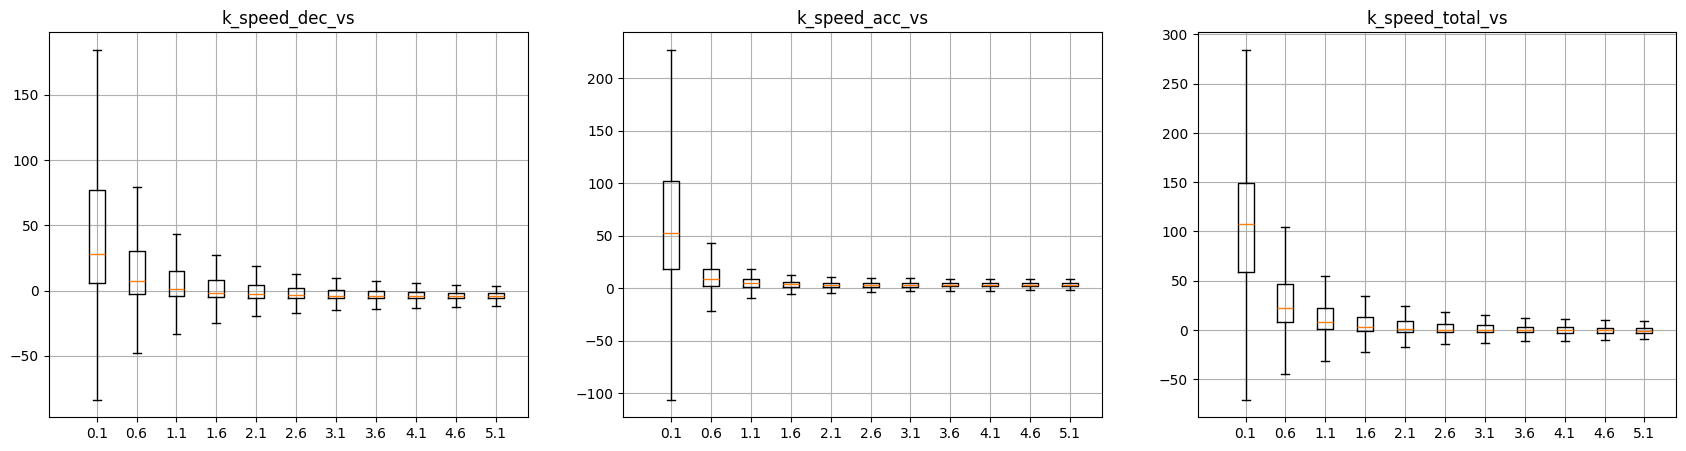

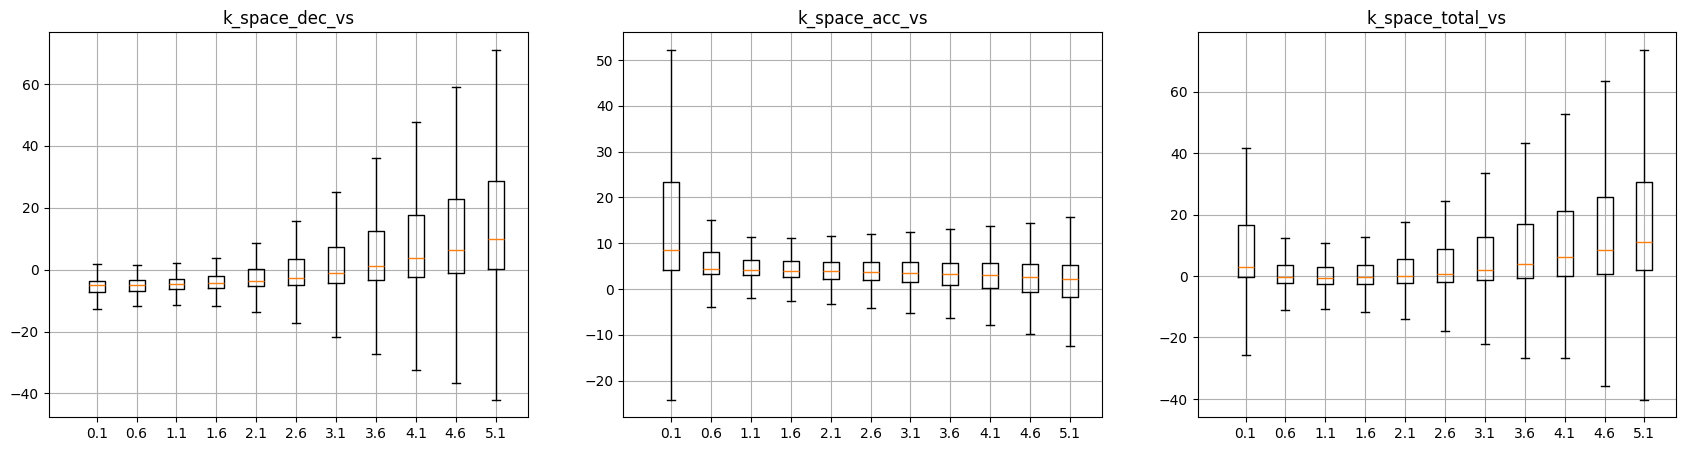

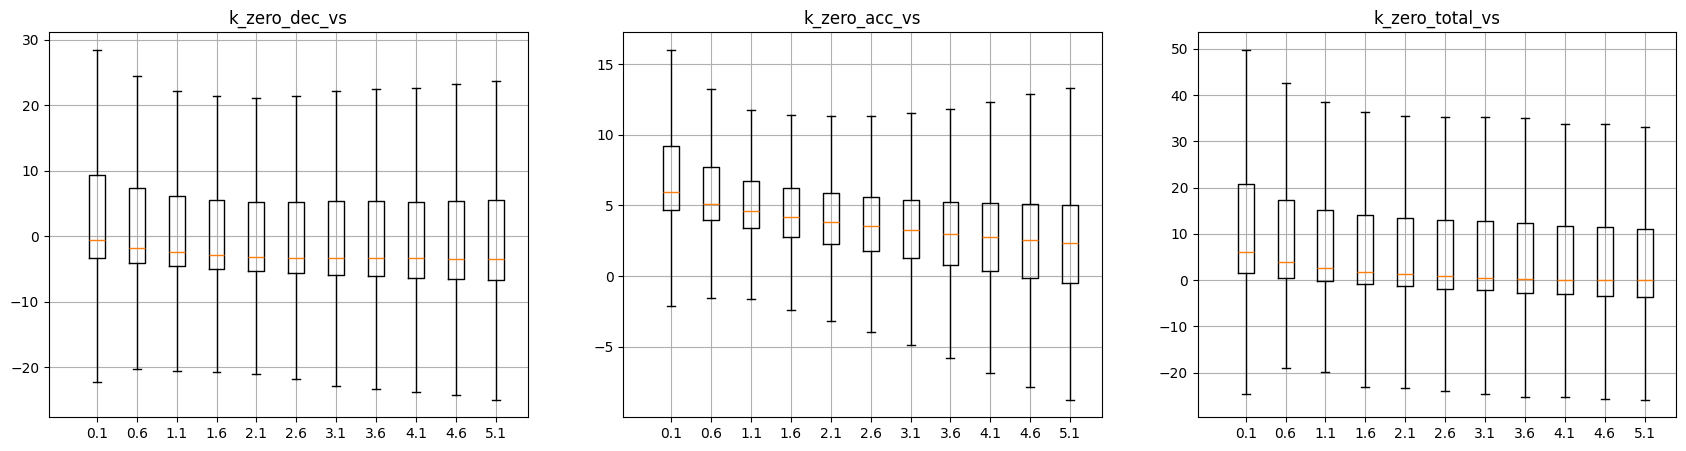

In [49]:
result_df = result_df[(np.isfinite(result_df["dec_vs"]) & np.isfinite(result_df["acc_vs"]))]
for k in ["k_speed", "k_space", "k_zero"]:
    temp: pd.DataFrame = result_df.groupby([k]).mean().reset_index()
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    axes: np.ndarray[plt.Axes] = axes
    # ax.plot(temp[k], temp["dec_vs"], label="dec_vs")
    # ax.plot(temp[k], temp["acc_vs"], label="acc_vs")
    # ax.plot(temp[k], temp["total_vs"], label="total_vs")
    
    for ax_, index in zip(axes, ["dec_vs", "acc_vs", "total_vs"]):
        ax_: plt.Axes = ax_
        ax_.boxplot([result_df[result_df[k] == i][index] for i in temp[k]], positions=temp[k], showfliers=False, widths=0.2)
        # ax_.set_xscale("log")
        # ax_.set_xticks(temp[k])
        ax_.set_xticklabels([f"{t:.1f}" for t in temp[k]])
        ax_.set_xlim([-0.5, 5.5])
        ax_.grid()
        ax_.set_title(k + "_" + index)
    fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result_{}.png".format(k))
result_df.to_csv(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result_infinite.csv", index=False)